#Missing Aircraft Detection
## By: Merwan Yeditha & Rohith Tatineni

# Introduction
The purpose of this notebook is to develop a Computer Vision Algorithm using a Convolutional Neural Network (CNN) that aids in the detection of missing airplanes. This algorithm will look at 20 pixels by 20 pixels satelliete images of various terrains containing an airplane. We believe that a computer vision algorithm is optimal for this task as it could greatly speed up the time it takes for search and rescrue teams to locate a missing aircraft by quickly parsing through satelliete images. 

We were particularly interested in this dataset as we want a final product with a potential for having a real positive impact on the world. Our algorithm can be used as a tool by search and rescue teams to help save lives. . We believe that the algorithm needs to achieve an accuracy of atleast 75% in order to be an effective tool. We would want an accuracy level this large because we do not want to mislead search and rescue teams and have them waste time and resources looking in the wrong area. In order to determine how well our data works, we will run the model against 1280 images it has not trained with and see how accurately it preforms. There are certain implications associated with this type of tool. Since the results of this tool could potentially decide the faith of someone's life, it is important for those using this algorithm to understand that this tool is not meant to make the final decision but instead reduce the time it takes to get to a final decision. The stakeholders of this algorithm consist of two parties, the search teams and the passengers of the missing plane.

In [ ]:
#Import statements for the libraries needed for this project
import gdown
import sys
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Import statement for pytorch
! pip install torchviz
import torch
torch.cuda.get_device_name(0)

In [ ]:
#Downloading the Dataset
gdown.download('https://drive.google.com/uc?authuser=0&id=16VuTHj77dRPXEzLsZu8u_chWOlaamLb7&export=download', 'archive.zip', quiet=True)
! unzip -q archive.zip

In [ ]:
#Copy model path from github
! git clone https://github.com/mmyeditha/Aircraft_Crash_Detection.git

In [ ]:
#Insert the saved model path
sys.path.insert(1, 'Aircraft_Crash_Detection')

# Dataset
The dataset we are using is from Kaggle and is titled "Missing Aircrafts". This dataset contains a total of 32080 images. Each image is 20 pixels by 20 pixels. There are 31080 training images which are catagorized as containing (1) or not containing (0) an airplane. 1000 test images are also provided where it is known that 200 of them contain airplanes.

## Dataset Investigation

After looking at our dataset, it appears that 'train.csv' contains two columns, one listing an image name and the other listing whether there is an aircraft present or not. The testing set has a similarly labeled csv file. 

It appears that our inputs will be the 400 pixels in these images, and the output will be a prediction of the probability that a plane exists 
in the image.

Below is a sample of a few of the images in our dataset along with their corresponding labels



Text(0.5, 1.0, '1')

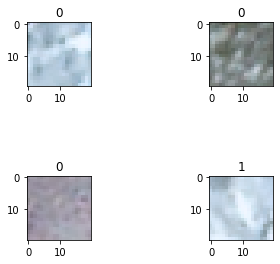

In [ ]:
data_label = pd.read_csv('train.csv')
imgs = ['avia_train/avia-train/'+x+'.png' for x in data_label.iloc[0:4,1].values]
labels = [x for x in data_label.iloc[0:4,0].values]
plt.subplot(321)
plt.imshow(cv2.imread(imgs[0]))
plt.title(labels[0])
plt.subplot(322)
plt.imshow(cv2.imread(imgs[1]))
plt.title(labels[1])
plt.subplot(325)
plt.imshow(cv2.imread(imgs[2]))
plt.title(labels[2])
plt.subplot(326)
plt.imshow(cv2.imread(imgs[3]))
plt.title(labels[3])

Something that we noticed when looking at small samples of the labels for all of our data was that there seemed to be far more images with no aircraft present than images with an aircraft present. To test this, we looked through our training csv file and counted the number of total images with no aircraft and the number of total images with an aircraft.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


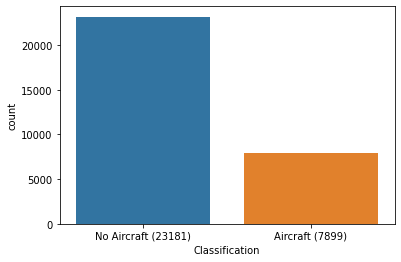

In [ ]:
data_label = pd.read_csv('train.csv')

sns.countplot(data_label.sign)
plt.xticks(ticks=range(2), labels=[f'No Aircraft ({sum(data_label.sign==0)})',f'Aircraft ({sum(data_label.sign==1)})'])
plt.xlabel('Classification')
plt.show()


As can be seen above, there are far more images that exist without an aircraft present. This skew in the training data may create bias in the model that will lead it to be more prone to predicting that an aircraft isn't present. In order to fix this though, we can train our model on a balanced subset of our data.

### Balancing the Dataset
To balance our data, we wrote an `organize_data` function that looks through all of the labels and corresponding image names and sorts an equal number of aircraft and non-aircraft images in test and validation folders.


In [ ]:
from organize_data import organize_data
organize_data(6400, 640)

In [ ]:
# turn label data into dictionary
data_label = pd.read_csv('train.csv')
data_label.iloc[:,1].values.tolist()
data_dict = dict(zip(data_label.iloc[:,1].values.tolist(), data_label.iloc[:,0].values.tolist()))

# check that files look right
print(len(os.listdir('train_set')), len(os.listdir('val_set')))
print(data_dict)

# Logistic Regression
Before jumping into creating a CNN, we first wanted to validate that a model of such complexity was neccesary to achieve the level of accuracy we felt was neccesary. In order to do this, we wanted to create a Logistic-Regression model. Using the Sci-Kit Toolbox we created and evelauted a  Logistic-Regression model.

### Dataset Manipulation
In order to use the data, we need to manipulate it to be in the right form. We first need to flatten these images and stack them into a numpy array. Since the images are 20x20 and there are 1000 images, the array will be 1000x400

In [ ]:
# Process training data
train_set = os.listdir('avia_train/avia-train')
X = np.zeros([31080,400])
for i, image in enumerate(train_set):
  img_arr = cv2.imread(f'avia_train/avia-train/{image}')
  img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
  img_flat = np.reshape(img_gray, [400])
  X[i, :] = img_flat.transpose()

Y = np.genfromtxt ('train.csv', delimiter=",")[1:,0]

### Principal Component Analysis
We ran a Principal Component Analysis (PCA) on this data in order to reduce the amount of datapoints per image. This will result in the logistic-regression model running faster but with similar levels of accuracy.

In [ ]:
from sklearn.decomposition import PCA
# Running PCA on testing data
X.shape
pca = PCA(n_components=25)
# applying dimensionality reduction for 30 most important components
fitted = pca.fit_transform(X)

### Creating and Evaluating the model
Using the Sci-Kit Toolbox, we were able to split the dataset into a training and testing datasets. We then created the model and generated a confusion matrix to evaluate how well the model performed. We found that this model did not work well as it would always guess that there was no plane present.

In [ ]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fitted, Y, test_size=0.33, random_state=42)

In [ ]:
# train the model
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(max_iter=10000000000,C=0.01).fit(X_train, y_train)
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

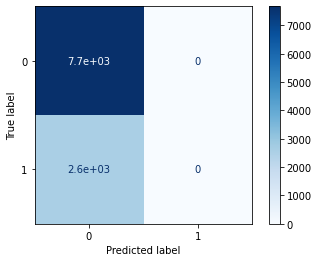

In [ ]:
# baby metric
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test, y_pred)
acc

# confusion matrix
from sklearn.metrics import plot_confusion_matrix
class_names=list(range(10)) # Gets names of each column.
plot_confusion_matrix(clf, X_test, y_test, display_labels=class_names,cmap=plt.cm.Blues)

It is interesting to look at the confusion matrix for this Linear-Regression model. It depicts how insufficient linear-regression is for this dataset as the model always guesses that there is no plane in the image. This showcases the need for a different type of model.

# Running through a CNN

After determining that a CNN was neccesary, we used Pytorch to create a CNN.

## Creating a Dataset Class

In order to use our data with PyTorch, we first had to create a dataset class and dataloader. We used pandas and open CV to format the data.

In [ ]:
import os
from dataloader import AirplaneCrashDataset
# sample output of the dataloader
loader_test = AirplaneCrashDataset(data_dict, split_set='train')
loader_test.__getitem__(12)

{'image': array([[[0.7411765 , 0.7411765 , 0.7607843 , ..., 0.7764706 ,
          0.78039217, 0.78039217],
         [0.72156864, 0.73333335, 0.7529412 , ..., 0.7529412 ,
          0.7529412 , 0.7372549 ],
         [0.7058824 , 0.73333335, 0.7372549 , ..., 0.7372549 ,
          0.7294118 , 0.7137255 ],
         ...,
         [0.654902  , 0.6       , 0.62352943, ..., 0.6039216 ,
          0.49803922, 0.42352942],
         [0.3764706 , 0.38431373, 0.35686275, ..., 0.5803922 ,
          0.5764706 , 0.5686275 ],
         [0.42352942, 0.49803922, 0.5254902 , ..., 0.7647059 ,
          0.7294118 , 0.7490196 ]],
 
        [[0.8117647 , 0.81960785, 0.8352941 , ..., 0.8627451 ,
          0.8666667 , 0.85882354],
         [0.7921569 , 0.8117647 , 0.83137256, ..., 0.8352941 ,
          0.8352941 , 0.8156863 ],
         [0.7764706 , 0.8117647 , 0.8235294 , ..., 0.8117647 ,
          0.8117647 , 0.79607844],
         ...,
         [0.7607843 , 0.7137255 , 0.7411765 , ..., 0.6627451 ,
          0.572

It's a bit hard to see with how much output there is, but the output is a dictionary with keys 'image' and 'label', where the image label corresponds to the normalized RGB values of one of the aircraft images, and label contains a 1 or 0 to represent whether an aircraft is present or not.

### Defining and Creating the Convolutional Neural Network

Using PyTorch we defined a CNN with 2 convulion layers, the first later with 32 kernels and the second with 12. We are using a GPU to compute our model since its faster processing times greatly expedites the optimization process. After defining the CNN, we created one and then initialized both the dataloader and dataset.

### Our Model Architecture
We began by developing a simple network which contained one convolutional layer followed by a pooling layer and two fully-connected layers. The convolutional layer would take in 128 kernels, then the pooling layer would reduce the overall dimensionality of the image to 128,000 total pixels (the original 20x20 images was 400,000). Then the fully connected layer would take in the 400,000 input neurons and output 64 neurons. The second fully connected layer would take in the 64 input neurons and output two, which correspond to the respective probability that an aircraft was either present or absent in the image.

We realized that this initial setup did not make much sense for our data, as only a single convolutional layer with such a large number of kernels did not make much sense given that our initial images were already very small.

We iterated by creating two convolutional layers which had 32 and 12 kernels respectively. This allowed for us to reduce the sizes of the images to 25 values after pooling, which we then inputted to the fully connected layers.

Below is a snippet of our code representing the layers of our model.
```
num_kernels_conv1 = 32
num_kernels_conv2 = 12
self.conv1 = nn.Conv2d(3,num_kernels_conv1, kernel_size=3,
  stride=1, padding=1)
self.conv2 = nn.Conv2d(32, num_kernels_conv2, kernel_size=3,
  stride=1, padding=1)
self.pool_conv1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
self.maxpool_output_size_conv1 = int(num_kernels_conv1 * 100) 
#int(num_kernels * (image_dims[1] / stride) * (image_dims[2] / stride))
self.pool_conv2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
self.maxpool_output_size_conv2 = int(num_kernels_conv2 * 25)

fc1_size = 64
self.fc1 = nn.Linear(self.maxpool_output_size_conv2, fc1_size)

self.activation_func = torch.nn.Sigmoid()

fc2_size = len(classes)
self.fc2 = nn.Linear(fc1_size, fc2_size)
```
### Forward Pass
In our model, our process for forward passes was quite simple. We would run the original data through the first convolutional layer, pool the results, and then run the pooled output through our activation function, for which we utilized the Sigmoid function. We repeated the same process for the second convolutional layer. After running our data through the convolutional layers, we flattened it and ran it through both fully connected layers, being sure to run through the activation function before feeding the first layer's output to the second.

Below is the code of us initializing the network and passing it to the GPU. Passing the network to the GPU provides some output that shows the specific parameters we defined for each of our convolutional and fully connected layers.


In [ ]:
from model import AirplaneCNN

In [ ]:
#Creating the model
net = AirplaneCNN()
device = 'cuda'
net.to(device) # 'cpu' if we want to not use the gpu

### Training the Model
We then began training the model. We optimized the model by manipulating the learning rate, the number of images in the training dataset, and the num of epochs. After several runs, we determined that a learning rate of 1 with 135 epochs determined an optimal result where the validation loss converged. We noticed that when we ran with more than 135 epochs, our training loss continued to decrease, but the validation loss would remain constant and even slightly increase, which showed us that the model was likely overtraining.

In order to execute this step, we had to create dataloaders. The code we utilized to do so is shown below.

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
# Initialize dataloader objects
TRAIN_DATA = AirplaneCrashDataset(data_dict, split_set = 'train')
TEST_DATA = AirplaneCrashDataset(data_dict, split_set='val')

# Set the number of images to use
n_training_samples = 6400
n_test_samples = 1280

# Create a sampler so that we can randomly sample images from test/val sets
train_sampler = SubsetRandomSampler(
    np.arange(n_training_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

# Create the torch dataloader objects
train_loader = DataLoader(TRAIN_DATA, batch_size=32, sampler=train_sampler)
test_loader = DataLoader(TEST_DATA, batch_size=32, sampler=test_sampler)

In [ ]:
learning_rate = 1
num_epochs = 135
#Training the model
from train_eval import train_model
train_hist_x, test_hist_x, train_loss_hist, test_loss_hist = train_model(net, learning_rate, num_epochs, train_loader, test_loader, device)

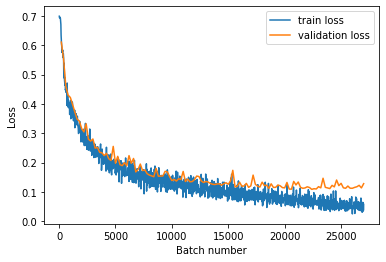

In [ ]:
#Plotting Loss Versus Batch
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

It is interesting to look at this graph of the train loss and validation loss over each epoch. This graph confirms that the model is not overfitted as both losses decrease. It is shows that more than 100 epochs are needed to maximize the accuracy of the model.

### Evaluating the Model

In order to evaluate the model, we created an evaluation script and ran the model on the validation data, saving the number of accurate predictions.

In [ ]:
from torch.autograd import Variable
def eval_model(net, test_loader, batch_size, device):
    net.eval()
    actuals = []
    preds = []
    for i, data in enumerate(test_loader):
        inputs = data['image']
        labels = data['label']
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
        outputs = net(inputs)

        for i in range(batch_size):
            img_tensor = outputs[i, :].cpu().detach().numpy()
            label = labels[i].cpu().detach().numpy()
            pred = np.where(img_tensor == (max(img_tensor)))[0][0]
            preds.append(pred)
            actuals.append(label)
    return preds, actuals
preds, actuals = eval_model(net, test_loader, 32, device)

Using these values, we can calculate the total accuracy and create a confusion matrix, which should tell us about our model's overall performance.

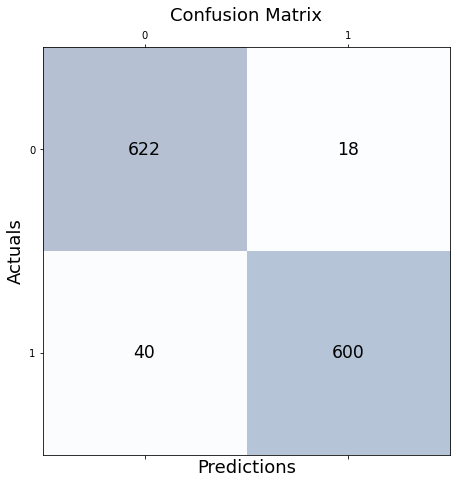

0.9546875


In [ ]:
from sklearn import metrics
conf_matrix = metrics.confusion_matrix(actuals, preds)
acc = metrics.accuracy_score(actuals, preds)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print(acc)

We found that overall, the model had an accuracy of 95%. 


Something interesting we found is that the model was more likely to have a false negative compared to a false positive which is negative error to have in our case. It is more beneficial to have a false positive and have a search team look in an area and not find a place versus having a search team not look in a place where there is a missing plane.

Finally, we will save the current model weights so that they can be used for future inferences without having to fully re-train the model.

In [ ]:
import torch
torch.save(net.state_dict(), 'checkpoint.pth')

# Conclusion

The model we developed is effective in finding a missing plane via satelliete imaging according to our parameters. The model achieved an accuracy of 95% which is greater than the 75% threshold we set. Our model would effectively aid in the search as is can parse through images at a rate of over 1000 a second but there are limitations. The model is currently trained on relatively small images where as typical satelliete data is much larger. Retraining the model the with larger images would require significant modifications to the CNN, as additional convolutional layers would be neccesary. Our dataset is also limited to just a generic commerical airliners which all have the same relative shape and color. With a broader dataset and some modifications, this alogirthm would be far more effective and could take on a greater share of the responisibility when making these critical decisions of where to search for survivors.